# FMLIKH Model: Small Amplitude Oscillatory Shear (SAOS)

## Learning Objectives

1. Generate **synthetic SAOS data** from NB07 calibrated parameters
2. Analyze **broadened relaxation spectra** with multi-mode fractional behavior
3. Compare FMLIKH vs single-mode FIKH frequency response
4. Understand multi-Maxwell-like behavior with fractional modifications

## Prerequisites

- NB07: FMLIKH Flow Curve (calibrated parameters)
- NB05: FIKH SAOS (single-mode concepts)

## 1. Setup

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"

In [2]:
%matplotlib inline
import os, sys, time, warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FMLIKH

# Robust path resolution for execution from any directory
from pathlib import Path
_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    load_fikh_parameters, generate_synthetic_saos, save_fikh_results,
    set_model_parameters, print_convergence_summary, get_fmlikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Load Calibrated Parameters

In [3]:
N_MODES = 3
model = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.7)

try:
    params = load_fikh_parameters("fmlikh", "flow_curve")
    set_model_parameters(model, params)
    print("Loaded parameters from NB07")
except FileNotFoundError:
    print("Using default parameters")

Loaded parameters from NB07


## 3. Generate Synthetic Data

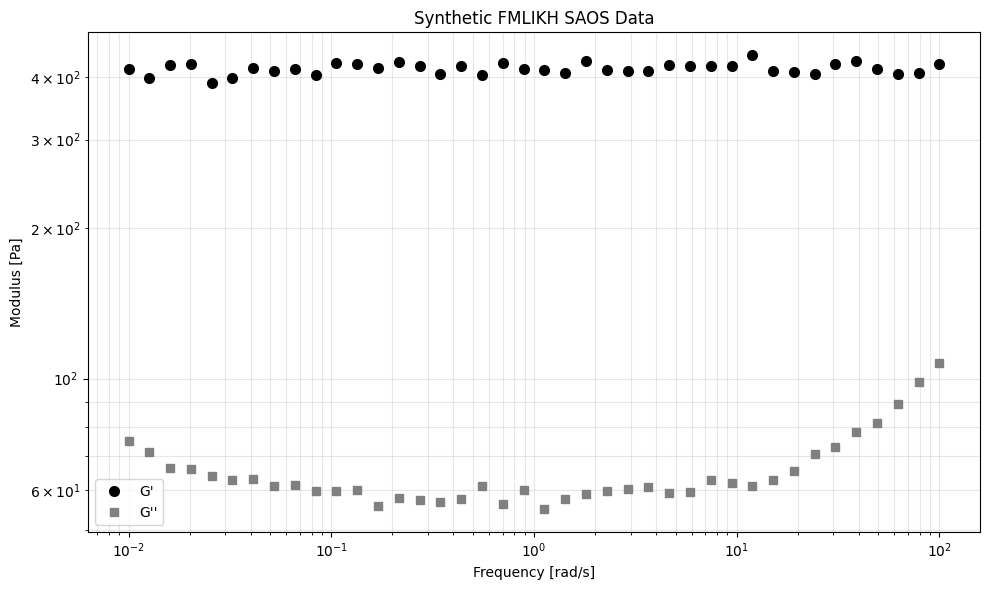

In [4]:
OMEGA_RANGE = (0.01, 100.0)
omega_data, G_prime_data, G_double_prime_data = generate_synthetic_saos(
    model, omega_range=OMEGA_RANGE, n_points=40, noise_level=0.03, seed=42
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(omega_data, G_prime_data, "ko", markersize=7, label="G'")
ax.loglog(omega_data, G_double_prime_data, "s", color="gray", markersize=6, label="G''")
ax.set_xlabel("Frequency [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("Synthetic FMLIKH SAOS Data")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. Mode Contribution Analysis

In [5]:
# Each mode has characteristic frequency 1/tau_i
mode_info = model.get_mode_info()
omega_fine = np.logspace(np.log10(OMEGA_RANGE[0]), np.log10(OMEGA_RANGE[1]), 100)

print("Mode characteristic frequencies:")
for m in mode_info["modes"]:
    omega_c = 1.0 / m["tau"] if m["tau"] > 0 else float("inf")
    print(f"  Mode {m['mode']}: ω_c = {omega_c:.4g} rad/s (τ = {m['tau']:.4g} s)")

Mode characteristic frequencies:
  Mode 0: ω_c = 0.001 rad/s (τ = 1000 s)
  Mode 1: ω_c = 0.001 rad/s (τ = 1000 s)
  Mode 2: ω_c = 0.001 rad/s (τ = 1000 s)


## 5. Bayesian Inference

In [6]:
model_fit = FMLIKH(n_modes=N_MODES, include_thermal=False, shared_alpha=True, alpha_structure=0.5)
G_star_data = G_prime_data + 1j * G_double_prime_data

# For SAOS, create synthetic time-domain oscillation data
# Use low frequency for fitting
omega_fit = np.median(omega_data)
period = 2 * np.pi / omega_fit
t_fit = np.linspace(0, 5 * period, 200)
gamma_0 = 0.01
strain_fit = gamma_0 * np.sin(omega_fit * t_fit)

# Use G_prime as proxy for stress magnitude (simplified)
stress_fit = G_prime_data[len(G_prime_data)//2] * strain_fit

model_fit.fit(t_fit, stress_fit, test_mode="startup", strain=strain_fit, method='scipy')

param_names = get_fmlikh_param_names(n_modes=N_MODES, shared_alpha=True)
initial_values = {n: model_fit.parameters.get_value(n) for n in param_names if n in model_fit.parameters}

NUM_WARMUP, NUM_SAMPLES, NUM_CHAINS = 200, 500, 1

t0 = time.time()
result = model_fit.fit_bayesian(
    t_fit, stress_fit, test_mode="startup", strain=strain_fit,
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
print(f"Bayesian time: {time.time() - t0:.1f} s")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fmlikh.py", line 532, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<11:30,  1.01it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|          | 5/700 [00:01<02:26,  4.75it/s, 63 steps of size 1.41e-03. acc. prob=0.40]

warmup:   1%|          | 6/700 [00:01<02:31,  4.58it/s, 63 steps of size 1.01e-03. acc. prob=0.49]

warmup:   1%|          | 7/700 [00:01<02:59,  3.86it/s, 127 steps of size 8.84e-04. acc. prob=0.56]

warmup:   1%|          | 8/700 [00:02<03:02,  3.80it/s, 108 steps of size 3.48e-04. acc. prob=0.58]

warmup:   1%|▏         | 9/700 [00:03<06:46,  1.70it/s, 511 steps of size 3.37e-04. acc. prob=0.63]

warmup:   1%|▏         | 10/700 [00:04<08:19,  1.38it/s, 398 steps of size 2.89e-04. acc. prob=0.66]

warmup:   2%|▏         | 11/700 [00:05<08:23,  1.37it/s, 255 steps of size 2.81e-04. acc. prob=0.69]

warmup:   2%|▏         | 12/700 [00:06<09:19,  1.23it/s, 380 steps of size 2.31e-04. acc. prob=0.71]

warmup:   2%|▏         | 13/700 [00:07<11:17,  1.01it/s, 511 steps of size 1.99e-04. acc. prob=0.72]

warmup:   2%|▏         | 14/700 [00:09<13:38,  1.19s/it, 511 steps of size 2.04e-04. acc. prob=0.74]

warmup:   2%|▏         | 15/700 [00:10<13:54,  1.22s/it, 458 steps of size 1.28e-04. acc. prob=0.75]

warmup:   2%|▏         | 16/700 [00:13<17:06,  1.50s/it, 750 steps of size 5.82e-05. acc. prob=0.75]

warmup:   2%|▏         | 17/700 [00:15<21:35,  1.90s/it, 1023 steps of size 5.61e-05. acc. prob=0.76]

warmup:   3%|▎         | 18/700 [00:18<24:51,  2.19s/it, 1023 steps of size 6.00e-05. acc. prob=0.77]

warmup:   3%|▎         | 19/700 [00:21<27:33,  2.43s/it, 1023 steps of size 6.57e-05. acc. prob=0.78]

warmup:   3%|▎         | 20/700 [00:24<29:11,  2.58s/it, 1023 steps of size 7.36e-05. acc. prob=0.79]

warmup:   3%|▎         | 21/700 [00:27<30:28,  2.69s/it, 1023 steps of size 7.08e-05. acc. prob=0.80]

warmup:   3%|▎         | 22/700 [00:30<31:31,  2.79s/it, 1023 steps of size 8.05e-05. acc. prob=0.81]

warmup:   3%|▎         | 23/700 [00:33<31:59,  2.84s/it, 1023 steps of size 4.74e-05. acc. prob=0.81]

warmup:   3%|▎         | 24/700 [00:36<32:07,  2.85s/it, 1023 steps of size 5.14e-05. acc. prob=0.81]

warmup:   4%|▎         | 25/700 [00:39<32:24,  2.88s/it, 1023 steps of size 5.46e-05. acc. prob=0.82]

warmup:   4%|▎         | 26/700 [00:42<32:40,  2.91s/it, 1023 steps of size 4.42e-05. acc. prob=0.82]

warmup:   4%|▍         | 27/700 [00:45<32:29,  2.90s/it, 1023 steps of size 4.18e-05. acc. prob=0.83]

warmup:   4%|▍         | 28/700 [00:48<32:28,  2.90s/it, 1023 steps of size 4.62e-05. acc. prob=0.83]

warmup:   4%|▍         | 29/700 [00:51<33:01,  2.95s/it, 1023 steps of size 4.78e-05. acc. prob=0.84]

warmup:   4%|▍         | 30/700 [00:54<32:40,  2.93s/it, 1023 steps of size 4.94e-05. acc. prob=0.84]

warmup:   4%|▍         | 31/700 [00:57<33:08,  2.97s/it, 1023 steps of size 4.16e-05. acc. prob=0.84]

warmup:   5%|▍         | 32/700 [01:00<32:57,  2.96s/it, 1023 steps of size 2.60e-05. acc. prob=0.84]

warmup:   5%|▍         | 33/700 [01:03<32:57,  2.96s/it, 1023 steps of size 2.67e-05. acc. prob=0.84]

warmup:   5%|▍         | 34/700 [01:06<33:06,  2.98s/it, 1023 steps of size 3.02e-05. acc. prob=0.85]

warmup:   5%|▌         | 35/700 [01:09<33:07,  2.99s/it, 1023 steps of size 3.19e-05. acc. prob=0.85]

warmup:   5%|▌         | 36/700 [01:12<33:14,  3.00s/it, 1023 steps of size 3.55e-05. acc. prob=0.86]

warmup:   5%|▌         | 37/700 [01:14<32:34,  2.95s/it, 1023 steps of size 3.79e-05. acc. prob=0.86]

warmup:   5%|▌         | 38/700 [01:17<32:17,  2.93s/it, 1023 steps of size 2.38e-05. acc. prob=0.86]

warmup:   6%|▌         | 39/700 [01:20<32:29,  2.95s/it, 1023 steps of size 2.50e-05. acc. prob=0.86]

warmup:   6%|▌         | 40/700 [01:23<32:18,  2.94s/it, 1023 steps of size 2.37e-05. acc. prob=0.86]

warmup:   6%|▌         | 41/700 [01:26<31:55,  2.91s/it, 1023 steps of size 2.67e-05. acc. prob=0.87]

warmup:   6%|▌         | 42/700 [01:29<32:06,  2.93s/it, 1023 steps of size 3.01e-05. acc. prob=0.87]

warmup:   6%|▌         | 43/700 [01:32<32:38,  2.98s/it, 1023 steps of size 3.23e-05. acc. prob=0.87]

warmup:   6%|▋         | 44/700 [01:35<32:11,  2.94s/it, 1023 steps of size 3.62e-05. acc. prob=0.87]

warmup:   6%|▋         | 45/700 [01:38<31:57,  2.93s/it, 1023 steps of size 3.55e-05. acc. prob=0.88]

warmup:   7%|▋         | 46/700 [01:41<32:00,  2.94s/it, 1023 steps of size 3.78e-05. acc. prob=0.88]

warmup:   7%|▋         | 47/700 [01:44<31:57,  2.94s/it, 1023 steps of size 3.94e-05. acc. prob=0.88]

warmup:   7%|▋         | 48/700 [01:47<31:58,  2.94s/it, 1023 steps of size 4.37e-05. acc. prob=0.88]

warmup:   7%|▋         | 49/700 [01:50<32:01,  2.95s/it, 1023 steps of size 3.20e-05. acc. prob=0.88]

warmup:   7%|▋         | 50/700 [01:53<31:48,  2.94s/it, 1023 steps of size 2.26e-05. acc. prob=0.88]

warmup:   7%|▋         | 51/700 [01:56<31:34,  2.92s/it, 1023 steps of size 2.44e-05. acc. prob=0.88]

warmup:   7%|▋         | 52/700 [01:58<31:08,  2.88s/it, 1023 steps of size 1.85e-05. acc. prob=0.88]

warmup:   8%|▊         | 53/700 [02:01<31:13,  2.90s/it, 1023 steps of size 1.89e-05. acc. prob=0.88]

warmup:   8%|▊         | 54/700 [02:04<31:20,  2.91s/it, 1023 steps of size 1.80e-05. acc. prob=0.88]

warmup:   8%|▊         | 55/700 [02:07<31:42,  2.95s/it, 1023 steps of size 1.94e-05. acc. prob=0.89]

warmup:   8%|▊         | 56/700 [02:10<31:10,  2.90s/it, 1023 steps of size 1.88e-05. acc. prob=0.89]

warmup:   8%|▊         | 57/700 [02:13<31:06,  2.90s/it, 1023 steps of size 2.05e-05. acc. prob=0.89]

warmup:   8%|▊         | 58/700 [02:16<31:07,  2.91s/it, 1023 steps of size 2.26e-05. acc. prob=0.89]

warmup:   8%|▊         | 59/700 [02:19<30:49,  2.89s/it, 1023 steps of size 1.92e-05. acc. prob=0.89]

warmup:   9%|▊         | 60/700 [02:22<30:49,  2.89s/it, 1023 steps of size 2.11e-05. acc. prob=0.89]

warmup:   9%|▊         | 61/700 [02:25<31:11,  2.93s/it, 1023 steps of size 2.03e-05. acc. prob=0.89]

warmup:   9%|▉         | 62/700 [02:28<31:17,  2.94s/it, 1023 steps of size 2.23e-05. acc. prob=0.89]

warmup:   9%|▉         | 63/700 [02:30<31:05,  2.93s/it, 1023 steps of size 1.67e-05. acc. prob=0.89]

warmup:   9%|▉         | 64/700 [02:33<30:57,  2.92s/it, 1023 steps of size 1.83e-05. acc. prob=0.89]

warmup:   9%|▉         | 65/700 [02:36<30:40,  2.90s/it, 1023 steps of size 2.01e-05. acc. prob=0.90]

warmup:   9%|▉         | 66/700 [02:39<31:04,  2.94s/it, 1023 steps of size 1.94e-05. acc. prob=0.90]

warmup:  10%|▉         | 67/700 [02:42<31:00,  2.94s/it, 1023 steps of size 2.05e-05. acc. prob=0.90]

warmup:  10%|▉         | 68/700 [02:45<31:19,  2.97s/it, 1023 steps of size 1.92e-05. acc. prob=0.90]

warmup:  10%|▉         | 69/700 [02:48<31:13,  2.97s/it, 1023 steps of size 2.11e-05. acc. prob=0.90]

warmup:  10%|█         | 70/700 [02:51<31:01,  2.96s/it, 1023 steps of size 1.80e-05. acc. prob=0.90]

warmup:  10%|█         | 71/700 [02:54<30:32,  2.91s/it, 1023 steps of size 1.54e-05. acc. prob=0.90]

warmup:  10%|█         | 72/700 [02:57<30:31,  2.92s/it, 1023 steps of size 1.65e-05. acc. prob=0.90]

warmup:  10%|█         | 73/700 [03:00<30:29,  2.92s/it, 1023 steps of size 1.81e-05. acc. prob=0.90]

warmup:  11%|█         | 74/700 [03:03<30:29,  2.92s/it, 1023 steps of size 1.24e-05. acc. prob=0.90]

warmup:  11%|█         | 75/700 [03:06<30:42,  2.95s/it, 1023 steps of size 1.36e-05. acc. prob=0.90]

warmup:  11%|█         | 76/700 [03:09<30:31,  2.93s/it, 1023 steps of size 1.47e-05. acc. prob=0.90]

warmup:  11%|█         | 77/700 [03:12<30:35,  2.95s/it, 1023 steps of size 1.50e-05. acc. prob=0.90]

warmup:  11%|█         | 78/700 [03:15<30:27,  2.94s/it, 1023 steps of size 1.63e-05. acc. prob=0.90]

warmup:  11%|█▏        | 79/700 [03:17<29:52,  2.89s/it, 1023 steps of size 1.08e-05. acc. prob=0.90]

warmup:  11%|█▏        | 80/700 [03:20<29:45,  2.88s/it, 1023 steps of size 1.15e-05. acc. prob=0.90]

warmup:  12%|█▏        | 81/700 [03:23<29:32,  2.86s/it, 1023 steps of size 1.25e-05. acc. prob=0.91]

warmup:  12%|█▏        | 82/700 [03:26<30:05,  2.92s/it, 1023 steps of size 1.35e-05. acc. prob=0.91]

warmup:  12%|█▏        | 83/700 [03:29<30:03,  2.92s/it, 1023 steps of size 1.47e-05. acc. prob=0.91]

warmup:  12%|█▏        | 84/700 [03:32<29:58,  2.92s/it, 1023 steps of size 1.29e-05. acc. prob=0.91]

warmup:  12%|█▏        | 85/700 [03:35<29:47,  2.91s/it, 1023 steps of size 1.22e-05. acc. prob=0.91]

warmup:  12%|█▏        | 86/700 [03:38<29:44,  2.91s/it, 1023 steps of size 1.32e-05. acc. prob=0.91]

warmup:  12%|█▏        | 87/700 [03:40<29:26,  2.88s/it, 1023 steps of size 1.39e-05. acc. prob=0.91]

warmup:  13%|█▎        | 88/700 [03:43<29:32,  2.90s/it, 1023 steps of size 1.25e-05. acc. prob=0.91]

warmup:  13%|█▎        | 89/700 [03:46<29:32,  2.90s/it, 1023 steps of size 1.30e-05. acc. prob=0.91]

warmup:  13%|█▎        | 90/700 [03:49<29:38,  2.92s/it, 1023 steps of size 1.40e-05. acc. prob=0.91]

warmup:  13%|█▎        | 91/700 [03:52<29:57,  2.95s/it, 1023 steps of size 1.51e-05. acc. prob=0.91]

warmup:  13%|█▎        | 92/700 [03:55<30:02,  2.96s/it, 1023 steps of size 1.61e-05. acc. prob=0.91]

warmup:  13%|█▎        | 93/700 [03:58<29:59,  2.96s/it, 1023 steps of size 9.94e-06. acc. prob=0.91]

warmup:  13%|█▎        | 94/700 [04:01<29:45,  2.95s/it, 1023 steps of size 1.06e-05. acc. prob=0.91]

warmup:  14%|█▎        | 95/700 [04:04<29:29,  2.93s/it, 1023 steps of size 1.03e-05. acc. prob=0.91]

warmup:  14%|█▎        | 96/700 [04:07<30:02,  2.98s/it, 1023 steps of size 9.85e-06. acc. prob=0.91]

warmup:  14%|█▍        | 97/700 [04:10<29:50,  2.97s/it, 1023 steps of size 1.06e-05. acc. prob=0.91]

warmup:  14%|█▍        | 98/700 [04:13<29:51,  2.98s/it, 1023 steps of size 1.12e-05. acc. prob=0.91]

warmup:  14%|█▍        | 99/700 [04:16<29:29,  2.94s/it, 1023 steps of size 1.05e-05. acc. prob=0.91]

warmup:  14%|█▍        | 100/700 [04:19<29:32,  2.95s/it, 1023 steps of size 1.13e-05. acc. prob=0.91]

warmup:  14%|█▍        | 101/700 [04:22<29:29,  2.95s/it, 1023 steps of size 1.15e-04. acc. prob=0.92]

warmup:  15%|█▍        | 102/700 [04:25<29:36,  2.97s/it, 1023 steps of size 1.19e-04. acc. prob=0.92]

warmup:  15%|█▍        | 103/700 [04:28<29:30,  2.97s/it, 1023 steps of size 1.23e-04. acc. prob=0.92]

warmup:  15%|█▍        | 104/700 [04:31<29:20,  2.95s/it, 1023 steps of size 1.27e-04. acc. prob=0.92]

warmup:  15%|█▌        | 105/700 [04:34<29:29,  2.97s/it, 1023 steps of size 1.31e-04. acc. prob=0.92]

warmup:  15%|█▌        | 106/700 [04:37<29:19,  2.96s/it, 1023 steps of size 1.36e-04. acc. prob=0.92]

warmup:  15%|█▌        | 107/700 [04:40<28:57,  2.93s/it, 1023 steps of size 1.40e-04. acc. prob=0.92]

warmup:  15%|█▌        | 108/700 [04:43<28:57,  2.93s/it, 1023 steps of size 1.45e-04. acc. prob=0.92]

warmup:  16%|█▌        | 109/700 [04:45<28:47,  2.92s/it, 1023 steps of size 1.50e-04. acc. prob=0.92]

warmup:  16%|█▌        | 110/700 [04:48<28:56,  2.94s/it, 1023 steps of size 1.55e-04. acc. prob=0.92]

warmup:  16%|█▌        | 111/700 [04:51<28:36,  2.91s/it, 1023 steps of size 1.59e-04. acc. prob=0.92]

warmup:  16%|█▌        | 112/700 [04:54<28:55,  2.95s/it, 1023 steps of size 1.64e-04. acc. prob=0.92]

warmup:  16%|█▌        | 113/700 [04:57<28:41,  2.93s/it, 1023 steps of size 1.69e-04. acc. prob=0.92]

warmup:  16%|█▋        | 114/700 [05:00<28:31,  2.92s/it, 1023 steps of size 1.72e-04. acc. prob=0.93]

warmup:  16%|█▋        | 115/700 [05:03<28:40,  2.94s/it, 1023 steps of size 1.77e-04. acc. prob=0.93]

warmup:  17%|█▋        | 116/700 [05:06<28:30,  2.93s/it, 1023 steps of size 1.82e-04. acc. prob=0.93]

warmup:  17%|█▋        | 117/700 [05:09<28:46,  2.96s/it, 1023 steps of size 1.86e-04. acc. prob=0.93]

warmup:  17%|█▋        | 118/700 [05:12<28:38,  2.95s/it, 1023 steps of size 1.90e-04. acc. prob=0.93]

warmup:  17%|█▋        | 119/700 [05:20<43:17,  4.47s/it, 1023 steps of size 1.95e-04. acc. prob=0.93]

warmup:  17%|█▋        | 120/700 [05:23<38:50,  4.02s/it, 1023 steps of size 2.00e-04. acc. prob=0.93]

warmup:  17%|█▋        | 121/700 [05:26<35:40,  3.70s/it, 1023 steps of size 2.02e-04. acc. prob=0.93]

warmup:  17%|█▋        | 122/700 [05:29<33:40,  3.50s/it, 1023 steps of size 2.07e-04. acc. prob=0.93]

warmup:  18%|█▊        | 123/700 [05:32<32:18,  3.36s/it, 1023 steps of size 2.12e-04. acc. prob=0.93]

warmup:  18%|█▊        | 124/700 [05:35<31:09,  3.25s/it, 1023 steps of size 2.17e-04. acc. prob=0.93]

warmup:  18%|█▊        | 125/700 [05:38<30:24,  3.17s/it, 1023 steps of size 2.21e-04. acc. prob=0.93]

warmup:  18%|█▊        | 126/700 [05:41<29:44,  3.11s/it, 1023 steps of size 2.26e-04. acc. prob=0.93]

warmup:  18%|█▊        | 127/700 [05:44<29:03,  3.04s/it, 1023 steps of size 2.31e-04. acc. prob=0.93]

warmup:  18%|█▊        | 128/700 [05:47<28:46,  3.02s/it, 1023 steps of size 2.27e-04. acc. prob=0.93]

warmup:  18%|█▊        | 129/700 [05:50<28:43,  3.02s/it, 1023 steps of size 2.31e-04. acc. prob=0.93]

warmup:  19%|█▊        | 130/700 [05:53<28:16,  2.98s/it, 1023 steps of size 2.35e-04. acc. prob=0.93]

warmup:  19%|█▊        | 131/700 [05:56<28:16,  2.98s/it, 1023 steps of size 2.40e-04. acc. prob=0.93]

warmup:  19%|█▉        | 132/700 [05:59<27:56,  2.95s/it, 1023 steps of size 2.45e-04. acc. prob=0.94]

warmup:  19%|█▉        | 133/700 [06:01<27:56,  2.96s/it, 1023 steps of size 2.48e-04. acc. prob=0.94]

warmup:  19%|█▉        | 134/700 [06:04<27:55,  2.96s/it, 1023 steps of size 2.51e-04. acc. prob=0.94]

warmup:  19%|█▉        | 135/700 [06:07<27:36,  2.93s/it, 1023 steps of size 2.55e-04. acc. prob=0.94]

warmup:  19%|█▉        | 136/700 [06:10<27:41,  2.95s/it, 1023 steps of size 2.59e-04. acc. prob=0.94]

warmup:  20%|█▉        | 137/700 [06:13<27:42,  2.95s/it, 1023 steps of size 2.64e-04. acc. prob=0.94]

warmup:  20%|█▉        | 138/700 [06:16<27:48,  2.97s/it, 1023 steps of size 2.69e-04. acc. prob=0.94]

warmup:  20%|█▉        | 139/700 [06:19<27:52,  2.98s/it, 1023 steps of size 2.71e-04. acc. prob=0.94]

warmup:  20%|██        | 140/700 [06:22<27:45,  2.97s/it, 1023 steps of size 2.77e-04. acc. prob=0.94]

warmup:  20%|██        | 141/700 [06:25<27:37,  2.96s/it, 1023 steps of size 2.72e-04. acc. prob=0.94]

warmup:  20%|██        | 142/700 [06:28<27:34,  2.97s/it, 1023 steps of size 2.77e-04. acc. prob=0.94]

warmup:  20%|██        | 143/700 [06:31<28:00,  3.02s/it, 1023 steps of size 2.81e-04. acc. prob=0.94]

warmup:  21%|██        | 144/700 [06:34<27:52,  3.01s/it, 1023 steps of size 2.76e-04. acc. prob=0.94]

warmup:  21%|██        | 145/700 [06:37<27:52,  3.01s/it, 1023 steps of size 2.81e-04. acc. prob=0.94]

warmup:  21%|██        | 146/700 [06:40<27:40,  3.00s/it, 1023 steps of size 2.86e-04. acc. prob=0.94]

warmup:  21%|██        | 147/700 [06:43<27:15,  2.96s/it, 1023 steps of size 2.86e-04. acc. prob=0.94]

warmup:  21%|██        | 148/700 [06:46<27:13,  2.96s/it, 1023 steps of size 2.89e-04. acc. prob=0.94]

warmup:  21%|██▏       | 149/700 [06:49<26:54,  2.93s/it, 1023 steps of size 2.92e-04. acc. prob=0.94]

warmup:  21%|██▏       | 150/700 [06:52<26:49,  2.93s/it, 1023 steps of size 2.97e-04. acc. prob=0.94]

warmup:  22%|██▏       | 151/700 [06:55<27:15,  2.98s/it, 1023 steps of size 3.02e-03. acc. prob=0.94]

warmup:  22%|██▏       | 153/700 [06:58<21:04,  2.31s/it, 1023 steps of size 2.88e-04. acc. prob=0.94]

warmup:  22%|██▏       | 154/700 [07:01<22:37,  2.49s/it, 1023 steps of size 2.50e-04. acc. prob=0.94]

warmup:  22%|██▏       | 155/700 [07:04<23:55,  2.63s/it, 1023 steps of size 2.31e-04. acc. prob=0.94]

warmup:  22%|██▏       | 156/700 [07:07<25:14,  2.78s/it, 1023 steps of size 2.23e-04. acc. prob=0.94]

warmup:  22%|██▏       | 157/700 [07:10<25:23,  2.81s/it, 1023 steps of size 2.20e-04. acc. prob=0.94]

warmup:  23%|██▎       | 158/700 [07:13<25:43,  2.85s/it, 1023 steps of size 2.20e-04. acc. prob=0.94]

warmup:  23%|██▎       | 159/700 [07:16<25:46,  2.86s/it, 1023 steps of size 2.21e-04. acc. prob=0.94]

warmup:  23%|██▎       | 160/700 [07:19<26:01,  2.89s/it, 1023 steps of size 2.27e-04. acc. prob=0.94]

warmup:  23%|██▎       | 161/700 [07:22<25:53,  2.88s/it, 1023 steps of size 2.35e-04. acc. prob=0.94]

warmup:  23%|██▎       | 162/700 [07:25<26:17,  2.93s/it, 1023 steps of size 2.43e-04. acc. prob=0.94]

warmup:  23%|██▎       | 163/700 [07:28<26:01,  2.91s/it, 1023 steps of size 2.53e-04. acc. prob=0.94]

warmup:  23%|██▎       | 164/700 [07:31<26:11,  2.93s/it, 1023 steps of size 2.65e-04. acc. prob=0.94]

warmup:  24%|██▎       | 165/700 [07:34<26:01,  2.92s/it, 1023 steps of size 2.77e-04. acc. prob=0.94]

warmup:  24%|██▎       | 166/700 [07:37<26:06,  2.93s/it, 1023 steps of size 2.82e-04. acc. prob=0.94]

warmup:  24%|██▍       | 167/700 [07:40<26:10,  2.95s/it, 1023 steps of size 2.96e-04. acc. prob=0.94]

warmup:  24%|██▍       | 168/700 [07:42<26:01,  2.93s/it, 1023 steps of size 3.01e-04. acc. prob=0.94]

warmup:  24%|██▍       | 169/700 [07:45<26:06,  2.95s/it, 1023 steps of size 3.15e-04. acc. prob=0.94]

warmup:  24%|██▍       | 170/700 [07:48<26:00,  2.94s/it, 1023 steps of size 3.30e-04. acc. prob=0.94]

warmup:  24%|██▍       | 171/700 [07:51<25:55,  2.94s/it, 1023 steps of size 3.46e-04. acc. prob=0.94]

warmup:  25%|██▍       | 172/700 [07:54<26:09,  2.97s/it, 1023 steps of size 3.62e-04. acc. prob=0.94]

warmup:  25%|██▍       | 173/700 [07:57<26:16,  2.99s/it, 1023 steps of size 3.57e-04. acc. prob=0.94]

warmup:  25%|██▍       | 174/700 [08:00<25:58,  2.96s/it, 1023 steps of size 3.74e-04. acc. prob=0.94]

warmup:  25%|██▌       | 175/700 [08:03<25:38,  2.93s/it, 1023 steps of size 3.85e-04. acc. prob=0.95]

warmup:  25%|██▌       | 176/700 [08:06<25:51,  2.96s/it, 1023 steps of size 4.03e-04. acc. prob=0.95]

warmup:  25%|██▌       | 177/700 [08:09<25:49,  2.96s/it, 1023 steps of size 4.21e-04. acc. prob=0.95]

warmup:  25%|██▌       | 178/700 [08:12<25:54,  2.98s/it, 1023 steps of size 4.38e-04. acc. prob=0.95]

warmup:  26%|██▌       | 179/700 [08:15<26:01,  3.00s/it, 1023 steps of size 4.26e-04. acc. prob=0.95]

warmup:  26%|██▌       | 180/700 [08:18<26:09,  3.02s/it, 1023 steps of size 4.20e-04. acc. prob=0.95]

warmup:  26%|██▌       | 181/700 [08:21<25:44,  2.98s/it, 1023 steps of size 4.38e-04. acc. prob=0.95]

warmup:  26%|██▌       | 182/700 [08:24<25:27,  2.95s/it, 1023 steps of size 3.91e-04. acc. prob=0.95]

warmup:  26%|██▌       | 183/700 [08:27<25:24,  2.95s/it, 1023 steps of size 3.98e-04. acc. prob=0.95]

warmup:  26%|██▋       | 184/700 [08:30<25:37,  2.98s/it, 1023 steps of size 4.15e-04. acc. prob=0.95]

warmup:  26%|██▋       | 185/700 [08:33<25:42,  2.99s/it, 1023 steps of size 4.29e-04. acc. prob=0.95]

warmup:  27%|██▋       | 186/700 [08:36<25:26,  2.97s/it, 1023 steps of size 4.47e-04. acc. prob=0.95]

warmup:  27%|██▋       | 187/700 [08:39<25:39,  3.00s/it, 1023 steps of size 4.55e-04. acc. prob=0.95]

warmup:  27%|██▋       | 188/700 [08:42<25:32,  2.99s/it, 1023 steps of size 4.13e-04. acc. prob=0.95]

warmup:  27%|██▋       | 189/700 [08:45<25:27,  2.99s/it, 1023 steps of size 4.26e-04. acc. prob=0.95]

warmup:  27%|██▋       | 190/700 [08:48<25:25,  2.99s/it, 1023 steps of size 4.18e-04. acc. prob=0.95]

warmup:  27%|██▋       | 191/700 [08:51<25:17,  2.98s/it, 1023 steps of size 4.34e-04. acc. prob=0.95]

warmup:  27%|██▋       | 192/700 [08:54<25:22,  3.00s/it, 1023 steps of size 4.47e-04. acc. prob=0.95]

warmup:  28%|██▊       | 193/700 [08:57<25:32,  3.02s/it, 1023 steps of size 4.60e-04. acc. prob=0.95]

warmup:  28%|██▊       | 194/700 [09:00<25:31,  3.03s/it, 1023 steps of size 4.76e-04. acc. prob=0.95]

warmup:  28%|██▊       | 195/700 [09:03<25:23,  3.02s/it, 1023 steps of size 4.92e-04. acc. prob=0.95]

warmup:  28%|██▊       | 196/700 [09:06<25:19,  3.02s/it, 1023 steps of size 5.09e-04. acc. prob=0.95]

warmup:  28%|██▊       | 197/700 [09:09<25:14,  3.01s/it, 1023 steps of size 5.22e-04. acc. prob=0.95]

warmup:  28%|██▊       | 198/700 [09:12<25:26,  3.04s/it, 1023 steps of size 5.41e-04. acc. prob=0.95]

warmup:  28%|██▊       | 199/700 [09:15<25:13,  3.02s/it, 1023 steps of size 5.55e-04. acc. prob=0.95]

warmup:  29%|██▊       | 200/700 [09:18<25:03,  3.01s/it, 1023 steps of size 4.33e-04. acc. prob=0.95]

sample:  29%|██▊       | 201/700 [09:21<25:18,  3.04s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  29%|██▉       | 202/700 [09:24<25:11,  3.04s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  29%|██▉       | 203/700 [09:27<25:16,  3.05s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  29%|██▉       | 204/700 [09:30<25:06,  3.04s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  29%|██▉       | 205/700 [09:33<24:35,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  29%|██▉       | 206/700 [09:36<24:40,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.97]

sample:  30%|██▉       | 207/700 [09:39<24:31,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  30%|██▉       | 208/700 [09:42<24:52,  3.03s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  30%|██▉       | 209/700 [09:45<24:52,  3.04s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  30%|███       | 210/700 [09:48<24:31,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  30%|███       | 211/700 [09:51<24:49,  3.05s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  30%|███       | 212/700 [09:55<24:50,  3.05s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  30%|███       | 213/700 [09:58<24:49,  3.06s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  31%|███       | 214/700 [10:01<24:37,  3.04s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  31%|███       | 215/700 [10:04<24:27,  3.03s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  31%|███       | 216/700 [10:07<24:33,  3.04s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  31%|███       | 217/700 [10:10<24:40,  3.07s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  31%|███       | 218/700 [10:13<24:43,  3.08s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  31%|███▏      | 219/700 [10:16<24:31,  3.06s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  31%|███▏      | 220/700 [10:19<24:03,  3.01s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  32%|███▏      | 221/700 [10:22<24:13,  3.03s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  32%|███▏      | 222/700 [10:25<24:04,  3.02s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  32%|███▏      | 223/700 [10:28<24:02,  3.02s/it, 1023 steps of size 4.33e-04. acc. prob=0.99]

sample:  32%|███▏      | 224/700 [10:31<23:34,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  32%|███▏      | 225/700 [10:34<23:16,  2.94s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  32%|███▏      | 226/700 [10:37<23:24,  2.96s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  32%|███▏      | 227/700 [10:40<23:31,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  33%|███▎      | 228/700 [10:43<23:27,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  33%|███▎      | 229/700 [10:46<23:18,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  33%|███▎      | 230/700 [10:49<23:24,  2.99s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  33%|███▎      | 231/700 [10:56<33:52,  4.33s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  33%|███▎      | 232/700 [10:59<31:01,  3.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  33%|███▎      | 233/700 [11:02<28:39,  3.68s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  33%|███▎      | 234/700 [11:05<26:57,  3.47s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  34%|███▎      | 235/700 [11:08<25:21,  3.27s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  34%|███▎      | 236/700 [11:11<24:48,  3.21s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  34%|███▍      | 237/700 [11:14<24:00,  3.11s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  34%|███▍      | 238/700 [11:17<24:03,  3.12s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  34%|███▍      | 239/700 [11:20<23:42,  3.09s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  34%|███▍      | 240/700 [11:23<23:41,  3.09s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  34%|███▍      | 241/700 [11:26<23:13,  3.04s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  35%|███▍      | 242/700 [11:29<23:10,  3.04s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  35%|███▍      | 243/700 [11:32<22:52,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  35%|███▍      | 244/700 [11:35<22:44,  2.99s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  35%|███▌      | 245/700 [11:38<22:40,  2.99s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  35%|███▌      | 246/700 [11:41<22:28,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  35%|███▌      | 247/700 [11:44<22:25,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  35%|███▌      | 248/700 [11:47<22:01,  2.92s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  36%|███▌      | 249/700 [11:50<22:01,  2.93s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  36%|███▌      | 250/700 [11:53<21:58,  2.93s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  36%|███▌      | 251/700 [11:56<21:54,  2.93s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  36%|███▌      | 252/700 [11:59<22:10,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  36%|███▌      | 253/700 [12:02<21:51,  2.93s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  36%|███▋      | 254/700 [12:04<21:49,  2.94s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  36%|███▋      | 255/700 [12:07<21:51,  2.95s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  37%|███▋      | 256/700 [12:10<21:51,  2.95s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  37%|███▋      | 257/700 [12:13<21:50,  2.96s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  37%|███▋      | 258/700 [12:16<21:45,  2.95s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  37%|███▋      | 259/700 [12:19<21:39,  2.95s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  37%|███▋      | 260/700 [12:22<21:45,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  37%|███▋      | 261/700 [12:25<21:40,  2.96s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  37%|███▋      | 262/700 [12:28<21:39,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  38%|███▊      | 263/700 [12:31<21:38,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  38%|███▊      | 264/700 [12:34<21:40,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  38%|███▊      | 265/700 [12:37<21:42,  2.99s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  38%|███▊      | 266/700 [12:40<21:40,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  38%|███▊      | 267/700 [12:43<21:21,  2.96s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  38%|███▊      | 268/700 [12:46<21:20,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  38%|███▊      | 269/700 [12:49<21:33,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  39%|███▊      | 270/700 [12:52<21:19,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  39%|███▊      | 271/700 [12:55<21:05,  2.95s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  39%|███▉      | 272/700 [12:58<21:05,  2.96s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  39%|███▉      | 273/700 [13:01<21:13,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  39%|███▉      | 274/700 [13:04<21:07,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.98]

sample:  39%|███▉      | 275/700 [13:07<21:20,  3.01s/it, 1023 steps of size 4.33e-04. acc. prob=0.97]

sample:  39%|███▉      | 276/700 [13:10<21:39,  3.06s/it, 1023 steps of size 4.33e-04. acc. prob=0.97]

sample:  40%|███▉      | 277/700 [13:13<21:23,  3.03s/it, 1023 steps of size 4.33e-04. acc. prob=0.97]

sample:  40%|███▉      | 278/700 [13:16<21:33,  3.07s/it, 1023 steps of size 4.33e-04. acc. prob=0.97]

sample:  40%|███▉      | 279/700 [13:19<21:14,  3.03s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  40%|████      | 280/700 [13:22<21:25,  3.06s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  40%|████      | 281/700 [13:26<21:40,  3.10s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  40%|████      | 282/700 [13:29<21:18,  3.06s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  40%|████      | 283/700 [13:31<20:55,  3.01s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  41%|████      | 284/700 [13:34<20:53,  3.01s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  41%|████      | 285/700 [13:37<20:32,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  41%|████      | 286/700 [13:40<20:40,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.95]

sample:  41%|████      | 287/700 [13:43<20:39,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  41%|████      | 288/700 [13:46<20:36,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  41%|████▏     | 289/700 [13:49<20:44,  3.03s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  41%|████▏     | 290/700 [13:52<20:37,  3.02s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  42%|████▏     | 291/700 [13:55<20:19,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  42%|████▏     | 292/700 [13:58<20:17,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.96]

sample:  42%|████▏     | 293/700 [14:01<20:05,  2.96s/it, 1023 steps of size 4.33e-04. acc. prob=0.95]

sample:  42%|████▏     | 294/700 [14:04<20:08,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.95]

sample:  42%|████▏     | 295/700 [14:07<19:57,  2.96s/it, 1023 steps of size 4.33e-04. acc. prob=0.95]

sample:  42%|████▏     | 296/700 [14:10<20:18,  3.02s/it, 1023 steps of size 4.33e-04. acc. prob=0.95]

sample:  42%|████▏     | 297/700 [14:13<20:06,  2.99s/it, 1023 steps of size 4.33e-04. acc. prob=0.95]

sample:  43%|████▎     | 298/700 [14:16<20:07,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.95]

sample:  43%|████▎     | 299/700 [14:19<19:50,  2.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  43%|████▎     | 300/700 [14:22<19:56,  2.99s/it, 1023 steps of size 4.33e-04. acc. prob=0.95]

sample:  43%|████▎     | 301/700 [14:25<19:56,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  43%|████▎     | 302/700 [14:28<19:54,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  43%|████▎     | 303/700 [14:31<19:50,  3.00s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  43%|████▎     | 304/700 [14:34<19:38,  2.98s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  44%|████▎     | 305/700 [14:37<19:21,  2.94s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  44%|████▎     | 306/700 [14:40<19:21,  2.95s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  44%|████▍     | 307/700 [14:43<19:21,  2.96s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  44%|████▍     | 308/700 [14:46<19:15,  2.95s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  44%|████▍     | 309/700 [14:49<19:29,  2.99s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  44%|████▍     | 310/700 [14:52<19:15,  2.96s/it, 1023 steps of size 4.33e-04. acc. prob=0.94]

sample:  44%|████▍     | 311/700 [14:55<19:10,  2.96s/it, 1023 steps of size 4.33e-04. acc. prob=0.93]

sample:  45%|████▍     | 312/700 [14:58<18:59,  2.94s/it, 1023 steps of size 4.33e-04. acc. prob=0.93]

sample:  45%|████▍     | 313/700 [15:01<18:55,  2.93s/it, 1023 steps of size 4.33e-04. acc. prob=0.93]

sample:  45%|████▍     | 314/700 [15:04<18:54,  2.94s/it, 1023 steps of size 4.33e-04. acc. prob=0.93]

sample:  45%|████▌     | 315/700 [15:07<18:49,  2.93s/it, 1023 steps of size 4.33e-04. acc. prob=0.92]

sample:  45%|████▌     | 316/700 [15:09<18:43,  2.93s/it, 1023 steps of size 4.33e-04. acc. prob=0.92]

sample:  45%|████▌     | 317/700 [15:12<18:19,  2.87s/it, 900 steps of size 4.33e-04. acc. prob=0.91] 

sample:  45%|████▌     | 318/700 [15:14<15:56,  2.51s/it, 567 steps of size 4.33e-04. acc. prob=0.91]

sample:  46%|████▌     | 319/700 [15:14<11:39,  1.84s/it, 95 steps of size 4.33e-04. acc. prob=0.90] 

sample:  46%|████▌     | 320/700 [15:16<12:04,  1.91s/it, 728 steps of size 4.33e-04. acc. prob=0.90]

sample:  46%|████▌     | 321/700 [15:18<11:53,  1.88s/it, 623 steps of size 4.33e-04. acc. prob=0.90]

sample:  46%|████▌     | 322/700 [15:20<11:31,  1.83s/it, 593 steps of size 4.33e-04. acc. prob=0.89]

sample:  46%|████▌     | 323/700 [15:20<08:53,  1.42s/it, 144 steps of size 4.33e-04. acc. prob=0.88]

sample:  46%|████▋     | 324/700 [15:21<07:12,  1.15s/it, 182 steps of size 4.33e-04. acc. prob=0.88]

sample:  46%|████▋     | 325/700 [15:22<06:40,  1.07s/it, 286 steps of size 4.33e-04. acc. prob=0.87]

sample:  47%|████▋     | 326/700 [15:25<10:15,  1.65s/it, 1023 steps of size 4.33e-04. acc. prob=0.86]

sample:  47%|████▋     | 327/700 [15:25<07:47,  1.25s/it, 117 steps of size 4.33e-04. acc. prob=0.86] 

sample:  47%|████▋     | 328/700 [15:26<07:25,  1.20s/it, 336 steps of size 4.33e-04. acc. prob=0.85]

sample:  47%|████▋     | 329/700 [15:27<07:06,  1.15s/it, 349 steps of size 4.33e-04. acc. prob=0.85]

sample:  47%|████▋     | 330/700 [15:30<10:40,  1.73s/it, 1023 steps of size 4.33e-04. acc. prob=0.84]

sample:  47%|████▋     | 331/700 [15:31<08:40,  1.41s/it, 237 steps of size 4.33e-04. acc. prob=0.84] 

sample:  47%|████▋     | 332/700 [15:32<08:17,  1.35s/it, 417 steps of size 4.33e-04. acc. prob=0.83]

sample:  48%|████▊     | 333/700 [15:34<08:42,  1.42s/it, 530 steps of size 4.33e-04. acc. prob=0.82]

sample:  48%|████▊     | 334/700 [15:34<07:06,  1.17s/it, 187 steps of size 4.33e-04. acc. prob=0.82]

sample:  48%|████▊     | 335/700 [15:34<05:12,  1.17it/s, 47 steps of size 4.33e-04. acc. prob=0.81] 

sample:  48%|████▊     | 336/700 [15:37<09:14,  1.52s/it, 1023 steps of size 4.33e-04. acc. prob=0.81]

sample:  48%|████▊     | 337/700 [15:38<08:27,  1.40s/it, 386 steps of size 4.33e-04. acc. prob=0.80] 

sample:  48%|████▊     | 338/700 [15:39<06:27,  1.07s/it, 107 steps of size 4.33e-04. acc. prob=0.80]

sample:  48%|████▊     | 339/700 [15:40<06:15,  1.04s/it, 352 steps of size 4.33e-04. acc. prob=0.79]

sample:  49%|████▊     | 340/700 [15:43<09:47,  1.63s/it, 1023 steps of size 4.33e-04. acc. prob=0.79]

sample:  49%|████▊     | 341/700 [15:44<09:00,  1.50s/it, 435 steps of size 4.33e-04. acc. prob=0.78] 

sample:  49%|████▉     | 342/700 [15:46<09:17,  1.56s/it, 583 steps of size 4.33e-04. acc. prob=0.78]

sample:  49%|████▉     | 343/700 [15:47<08:51,  1.49s/it, 473 steps of size 4.33e-04. acc. prob=0.77]

sample:  49%|████▉     | 344/700 [15:50<11:40,  1.97s/it, 1023 steps of size 4.33e-04. acc. prob=0.77]

sample:  49%|████▉     | 345/700 [15:52<11:19,  1.91s/it, 601 steps of size 4.33e-04. acc. prob=0.76] 

sample:  49%|████▉     | 346/700 [15:54<12:01,  2.04s/it, 817 steps of size 4.33e-04. acc. prob=0.76]

sample:  50%|████▉     | 347/700 [15:57<13:07,  2.23s/it, 840 steps of size 4.33e-04. acc. prob=0.76]

sample:  50%|████▉     | 348/700 [15:58<11:37,  1.98s/it, 449 steps of size 4.33e-04. acc. prob=0.75]

sample:  50%|████▉     | 349/700 [15:59<10:11,  1.74s/it, 392 steps of size 4.33e-04. acc. prob=0.75]

sample:  50%|█████     | 350/700 [16:00<08:41,  1.49s/it, 297 steps of size 4.33e-04. acc. prob=0.75]

sample:  50%|█████     | 351/700 [16:01<07:27,  1.28s/it, 266 steps of size 4.33e-04. acc. prob=0.75]

sample:  50%|█████     | 352/700 [16:04<10:42,  1.85s/it, 1023 steps of size 4.33e-04. acc. prob=0.74]

sample:  50%|█████     | 353/700 [16:05<08:46,  1.52s/it, 240 steps of size 4.33e-04. acc. prob=0.74] 

sample:  51%|█████     | 354/700 [16:06<07:59,  1.39s/it, 372 steps of size 4.33e-04. acc. prob=0.73]

sample:  51%|█████     | 355/700 [16:08<08:22,  1.46s/it, 555 steps of size 4.33e-04. acc. prob=0.73]

sample:  51%|█████     | 356/700 [16:09<08:16,  1.44s/it, 470 steps of size 4.33e-04. acc. prob=0.73]

sample:  51%|█████     | 357/700 [16:10<06:46,  1.19s/it, 188 steps of size 4.33e-04. acc. prob=0.72]

sample:  51%|█████     | 358/700 [16:11<06:35,  1.16s/it, 379 steps of size 4.33e-04. acc. prob=0.72]

sample:  51%|█████▏    | 359/700 [16:14<09:39,  1.70s/it, 1023 steps of size 4.33e-04. acc. prob=0.72]

sample:  51%|█████▏    | 360/700 [16:17<11:45,  2.08s/it, 1023 steps of size 4.33e-04. acc. prob=0.72]

sample:  52%|█████▏    | 361/700 [16:20<12:59,  2.30s/it, 1023 steps of size 4.33e-04. acc. prob=0.72]

sample:  52%|█████▏    | 362/700 [16:22<13:56,  2.48s/it, 1023 steps of size 4.33e-04. acc. prob=0.71]

sample:  52%|█████▏    | 363/700 [16:25<14:35,  2.60s/it, 1023 steps of size 4.33e-04. acc. prob=0.71]

sample:  52%|█████▏    | 364/700 [16:26<12:07,  2.16s/it, 392 steps of size 4.33e-04. acc. prob=0.71] 

sample:  52%|█████▏    | 365/700 [16:30<13:31,  2.42s/it, 1023 steps of size 4.33e-04. acc. prob=0.71]

sample:  52%|█████▏    | 366/700 [16:32<13:06,  2.35s/it, 774 steps of size 4.33e-04. acc. prob=0.71] 

sample:  52%|█████▏    | 367/700 [16:34<12:27,  2.24s/it, 703 steps of size 4.33e-04. acc. prob=0.70]

sample:  53%|█████▎    | 368/700 [16:36<12:02,  2.18s/it, 692 steps of size 4.33e-04. acc. prob=0.70]

sample:  53%|█████▎    | 369/700 [16:38<12:22,  2.24s/it, 843 steps of size 4.33e-04. acc. prob=0.70]

sample:  53%|█████▎    | 370/700 [16:40<12:10,  2.21s/it, 763 steps of size 4.33e-04. acc. prob=0.70]

sample:  53%|█████▎    | 371/700 [16:43<12:51,  2.35s/it, 930 steps of size 4.33e-04. acc. prob=0.69]

sample:  53%|█████▎    | 372/700 [16:44<10:51,  1.99s/it, 405 steps of size 4.33e-04. acc. prob=0.69]

sample:  53%|█████▎    | 373/700 [16:45<08:27,  1.55s/it, 190 steps of size 4.33e-04. acc. prob=0.69]

sample:  53%|█████▎    | 374/700 [16:45<06:28,  1.19s/it, 126 steps of size 4.33e-04. acc. prob=0.68]

sample:  54%|█████▍    | 377/700 [16:45<03:03,  1.76it/s, 60 steps of size 4.33e-04. acc. prob=0.67] 

sample:  54%|█████▍    | 378/700 [16:46<02:59,  1.79it/s, 188 steps of size 4.33e-04. acc. prob=0.67]

sample:  54%|█████▍    | 379/700 [16:49<05:54,  1.10s/it, 1023 steps of size 4.33e-04. acc. prob=0.66]

sample:  54%|█████▍    | 380/700 [16:50<06:31,  1.22s/it, 535 steps of size 4.33e-04. acc. prob=0.66] 

sample:  54%|█████▍    | 381/700 [16:51<05:24,  1.02s/it, 159 steps of size 4.33e-04. acc. prob=0.66]

sample:  55%|█████▍    | 382/700 [16:51<04:49,  1.10it/s, 230 steps of size 4.33e-04. acc. prob=0.66]

sample:  55%|█████▍    | 383/700 [16:53<05:54,  1.12s/it, 582 steps of size 4.33e-04. acc. prob=0.66]

sample:  55%|█████▍    | 384/700 [16:55<07:36,  1.44s/it, 798 steps of size 4.33e-04. acc. prob=0.66]

sample:  55%|█████▌    | 385/700 [16:57<07:46,  1.48s/it, 557 steps of size 4.33e-04. acc. prob=0.65]

sample:  55%|█████▌    | 386/700 [16:58<07:21,  1.41s/it, 432 steps of size 4.33e-04. acc. prob=0.65]

sample:  55%|█████▌    | 387/700 [16:59<06:10,  1.18s/it, 235 steps of size 4.33e-04. acc. prob=0.65]

sample:  55%|█████▌    | 388/700 [16:59<05:12,  1.00s/it, 191 steps of size 4.33e-04. acc. prob=0.65]

sample:  56%|█████▌    | 389/700 [17:00<04:41,  1.10it/s, 249 steps of size 4.33e-04. acc. prob=0.65]

sample:  56%|█████▌    | 390/700 [17:02<06:47,  1.31s/it, 800 steps of size 4.33e-04. acc. prob=0.65]

sample:  56%|█████▌    | 391/700 [17:04<08:16,  1.61s/it, 785 steps of size 4.33e-04. acc. prob=0.64]

sample:  56%|█████▌    | 392/700 [17:07<09:24,  1.83s/it, 837 steps of size 4.33e-04. acc. prob=0.64]

sample:  56%|█████▌    | 393/700 [17:08<08:59,  1.76s/it, 567 steps of size 4.33e-04. acc. prob=0.64]

sample:  56%|█████▋    | 394/700 [17:11<10:37,  2.08s/it, 1023 steps of size 4.33e-04. acc. prob=0.64]

sample:  57%|█████▋    | 396/700 [17:12<06:08,  1.21s/it, 107 steps of size 4.33e-04. acc. prob=0.63] 

sample:  57%|█████▋    | 397/700 [17:12<04:47,  1.05it/s, 52 steps of size 4.33e-04. acc. prob=0.63] 

sample:  57%|█████▋    | 399/700 [17:12<03:22,  1.49it/s, 188 steps of size 4.33e-04. acc. prob=0.62]

sample:  57%|█████▋    | 400/700 [17:15<05:56,  1.19s/it, 1023 steps of size 4.33e-04. acc. prob=0.62]

sample:  57%|█████▋    | 401/700 [17:18<07:53,  1.58s/it, 1023 steps of size 4.33e-04. acc. prob=0.62]

sample:  57%|█████▋    | 402/700 [17:19<07:30,  1.51s/it, 455 steps of size 4.33e-04. acc. prob=0.61] 

sample:  58%|█████▊    | 403/700 [17:21<07:41,  1.55s/it, 594 steps of size 4.33e-04. acc. prob=0.61]

sample:  58%|█████▊    | 404/700 [17:22<07:30,  1.52s/it, 491 steps of size 4.33e-04. acc. prob=0.61]

sample:  58%|█████▊    | 405/700 [17:24<07:35,  1.55s/it, 543 steps of size 4.33e-04. acc. prob=0.61]

sample:  58%|█████▊    | 407/700 [17:24<04:18,  1.13it/s, 19 steps of size 4.33e-04. acc. prob=0.60] 

sample:  58%|█████▊    | 408/700 [17:25<03:41,  1.32it/s, 121 steps of size 4.33e-04. acc. prob=0.60]

sample:  58%|█████▊    | 409/700 [17:25<03:14,  1.49it/s, 141 steps of size 4.33e-04. acc. prob=0.60]

sample:  59%|█████▊    | 410/700 [17:28<06:10,  1.28s/it, 1023 steps of size 4.33e-04. acc. prob=0.60]

sample:  59%|█████▊    | 411/700 [17:30<06:41,  1.39s/it, 600 steps of size 4.33e-04. acc. prob=0.59] 

sample:  59%|█████▉    | 412/700 [17:30<05:39,  1.18s/it, 216 steps of size 4.33e-04. acc. prob=0.59]

sample:  59%|█████▉    | 413/700 [17:31<05:05,  1.06s/it, 264 steps of size 4.33e-04. acc. prob=0.59]

sample:  59%|█████▉    | 415/700 [17:31<03:01,  1.57it/s, 47 steps of size 4.33e-04. acc. prob=0.58] 

sample:  60%|█████▉    | 417/700 [17:32<02:07,  2.23it/s, 86 steps of size 4.33e-04. acc. prob=0.58]

sample:  60%|█████▉    | 419/700 [17:32<01:40,  2.80it/s, 135 steps of size 4.33e-04. acc. prob=0.58]

sample:  60%|██████    | 420/700 [17:32<01:32,  3.03it/s, 88 steps of size 4.33e-04. acc. prob=0.57] 

sample:  60%|██████    | 422/700 [17:34<02:19,  1.99it/s, 532 steps of size 4.33e-04. acc. prob=0.57]

sample:  61%|██████    | 425/700 [17:34<01:30,  3.05it/s, 73 steps of size 4.33e-04. acc. prob=0.56] 

sample:  61%|██████    | 426/700 [17:34<01:19,  3.43it/s, 44 steps of size 4.33e-04. acc. prob=0.56]

sample:  61%|██████    | 428/700 [17:34<01:01,  4.44it/s, 35 steps of size 4.33e-04. acc. prob=0.55]

sample:  61%|██████▏   | 430/700 [17:35<00:46,  5.79it/s, 29 steps of size 4.33e-04. acc. prob=0.55]

sample:  62%|██████▏   | 432/700 [17:35<00:40,  6.56it/s, 61 steps of size 4.33e-04. acc. prob=0.55]

sample:  62%|██████▏   | 434/700 [17:35<00:43,  6.15it/s, 96 steps of size 4.33e-04. acc. prob=0.54]

sample:  62%|██████▏   | 436/700 [17:35<00:37,  7.07it/s, 56 steps of size 4.33e-04. acc. prob=0.54]

sample:  62%|██████▏   | 437/700 [17:35<00:37,  7.10it/s, 46 steps of size 4.33e-04. acc. prob=0.54]

sample:  63%|██████▎   | 438/700 [17:36<00:36,  7.28it/s, 43 steps of size 4.33e-04. acc. prob=0.53]

sample:  63%|██████▎   | 439/700 [17:36<01:12,  3.60it/s, 272 steps of size 4.33e-04. acc. prob=0.53]

sample:  63%|██████▎   | 440/700 [17:36<01:02,  4.17it/s, 35 steps of size 4.33e-04. acc. prob=0.53] 

sample:  63%|██████▎   | 442/700 [17:37<00:50,  5.11it/s, 61 steps of size 4.33e-04. acc. prob=0.53]

sample:  63%|██████▎   | 444/700 [17:37<00:36,  6.92it/s, 13 steps of size 4.33e-04. acc. prob=0.52]

sample:  64%|██████▎   | 446/700 [17:37<00:29,  8.57it/s, 18 steps of size 4.33e-04. acc. prob=0.52]

sample:  64%|██████▍   | 448/700 [17:37<00:29,  8.54it/s, 61 steps of size 4.33e-04. acc. prob=0.52]

sample:  64%|██████▍   | 450/700 [17:37<00:26,  9.55it/s, 27 steps of size 4.33e-04. acc. prob=0.51]

sample:  65%|██████▍   | 452/700 [17:38<00:26,  9.43it/s, 52 steps of size 4.33e-04. acc. prob=0.51]

sample:  65%|██████▍   | 454/700 [17:38<00:27,  8.91it/s, 69 steps of size 4.33e-04. acc. prob=0.51]

sample:  65%|██████▌   | 456/700 [17:38<00:22, 10.74it/s, 16 steps of size 4.33e-04. acc. prob=0.50]

sample:  65%|██████▌   | 458/700 [17:38<00:21, 11.14it/s, 18 steps of size 4.33e-04. acc. prob=0.50]

sample:  66%|██████▌   | 460/700 [17:38<00:27,  8.84it/s, 30 steps of size 4.33e-04. acc. prob=0.50]

sample:  66%|██████▌   | 462/700 [17:39<00:29,  8.13it/s, 60 steps of size 4.33e-04. acc. prob=0.49]

sample:  66%|██████▋   | 464/700 [17:39<00:27,  8.66it/s, 39 steps of size 4.33e-04. acc. prob=0.49]

sample:  67%|██████▋   | 466/700 [17:39<00:23,  9.97it/s, 21 steps of size 4.33e-04. acc. prob=0.49]

sample:  67%|██████▋   | 468/700 [17:39<00:21, 10.62it/s, 21 steps of size 4.33e-04. acc. prob=0.48]

sample:  67%|██████▋   | 470/700 [17:39<00:21, 10.79it/s, 31 steps of size 4.33e-04. acc. prob=0.48]

sample:  67%|██████▋   | 472/700 [17:40<00:18, 12.50it/s, 23 steps of size 4.33e-04. acc. prob=0.48]

sample:  68%|██████▊   | 474/700 [17:40<00:20, 11.13it/s, 54 steps of size 4.33e-04. acc. prob=0.47]

sample:  68%|██████▊   | 476/700 [17:40<00:22, 10.14it/s, 23 steps of size 4.33e-04. acc. prob=0.47]

sample:  68%|██████▊   | 478/700 [17:40<00:26,  8.23it/s, 50 steps of size 4.33e-04. acc. prob=0.47]

sample:  69%|██████▊   | 480/700 [17:40<00:22,  9.81it/s, 18 steps of size 4.33e-04. acc. prob=0.47]

sample:  69%|██████▉   | 482/700 [17:41<00:41,  5.24it/s, 268 steps of size 4.33e-04. acc. prob=0.46]

sample:  69%|██████▉   | 484/700 [17:41<00:33,  6.38it/s, 41 steps of size 4.33e-04. acc. prob=0.46] 

sample:  69%|██████▉   | 486/700 [17:42<00:29,  7.25it/s, 37 steps of size 4.33e-04. acc. prob=0.46]

sample:  70%|██████▉   | 488/700 [17:42<00:27,  7.83it/s, 52 steps of size 4.33e-04. acc. prob=0.45]

sample:  70%|███████   | 490/700 [17:42<00:22,  9.21it/s, 20 steps of size 4.33e-04. acc. prob=0.45]

sample:  70%|███████   | 492/700 [17:42<00:20,  9.95it/s, 33 steps of size 4.33e-04. acc. prob=0.45]

sample:  71%|███████   | 494/700 [17:42<00:20, 10.04it/s, 42 steps of size 4.33e-04. acc. prob=0.45]

sample:  71%|███████   | 496/700 [17:42<00:19, 10.59it/s, 29 steps of size 4.33e-04. acc. prob=0.44]

sample:  71%|███████   | 498/700 [17:43<00:20,  9.88it/s, 58 steps of size 4.33e-04. acc. prob=0.44]

sample:  71%|███████▏  | 500/700 [17:43<00:21,  9.23it/s, 15 steps of size 4.33e-04. acc. prob=0.44]

sample:  72%|███████▏  | 502/700 [17:43<00:20,  9.71it/s, 46 steps of size 4.33e-04. acc. prob=0.44]

sample:  72%|███████▏  | 505/700 [17:43<00:21,  9.26it/s, 91 steps of size 4.33e-04. acc. prob=0.43]

sample:  72%|███████▏  | 506/700 [17:44<00:22,  8.55it/s, 59 steps of size 4.33e-04. acc. prob=0.43]

sample:  73%|███████▎  | 508/700 [17:44<00:19,  9.89it/s, 29 steps of size 4.33e-04. acc. prob=0.43]

sample:  73%|███████▎  | 510/700 [17:44<00:18, 10.15it/s, 36 steps of size 4.33e-04. acc. prob=0.43]

sample:  73%|███████▎  | 512/700 [17:44<00:16, 11.29it/s, 41 steps of size 4.33e-04. acc. prob=0.43]

sample:  73%|███████▎  | 514/700 [17:44<00:14, 12.66it/s, 21 steps of size 4.33e-04. acc. prob=0.42]

sample:  74%|███████▎  | 516/700 [17:44<00:14, 13.14it/s, 28 steps of size 4.33e-04. acc. prob=0.42]

sample:  74%|███████▍  | 518/700 [17:45<00:15, 11.46it/s, 39 steps of size 4.33e-04. acc. prob=0.42]

sample:  74%|███████▍  | 521/700 [17:45<00:13, 13.40it/s, 29 steps of size 4.33e-04. acc. prob=0.41]

sample:  75%|███████▍  | 523/700 [17:45<00:16, 10.94it/s, 57 steps of size 4.33e-04. acc. prob=0.41]

sample:  75%|███████▌  | 525/700 [17:45<00:19,  9.05it/s, 89 steps of size 4.33e-04. acc. prob=0.41]

sample:  75%|███████▌  | 527/700 [17:46<00:19,  8.69it/s, 64 steps of size 4.33e-04. acc. prob=0.41]

sample:  76%|███████▌  | 529/700 [17:46<00:19,  8.96it/s, 59 steps of size 4.33e-04. acc. prob=0.41]

sample:  76%|███████▌  | 531/700 [17:46<00:17,  9.65it/s, 28 steps of size 4.33e-04. acc. prob=0.41]

sample:  76%|███████▌  | 533/700 [17:46<00:19,  8.38it/s, 60 steps of size 4.33e-04. acc. prob=0.40]

sample:  76%|███████▋  | 534/700 [17:46<00:19,  8.46it/s, 33 steps of size 4.33e-04. acc. prob=0.40]

sample:  76%|███████▋  | 535/700 [17:46<00:20,  8.16it/s, 49 steps of size 4.33e-04. acc. prob=0.40]

sample:  77%|███████▋  | 537/700 [17:47<00:16,  9.77it/s, 27 steps of size 4.33e-04. acc. prob=0.40]

sample:  77%|███████▋  | 539/700 [17:47<00:13, 11.66it/s, 13 steps of size 4.33e-04. acc. prob=0.40]

sample:  77%|███████▋  | 541/700 [17:47<00:14, 11.15it/s, 28 steps of size 4.33e-04. acc. prob=0.40]

sample:  78%|███████▊  | 543/700 [17:47<00:13, 11.59it/s, 23 steps of size 4.33e-04. acc. prob=0.39]

sample:  78%|███████▊  | 545/700 [17:47<00:15, 10.18it/s, 48 steps of size 4.33e-04. acc. prob=0.39]

sample:  78%|███████▊  | 548/700 [17:48<00:13, 11.53it/s, 43 steps of size 4.33e-04. acc. prob=0.39]

sample:  79%|███████▊  | 550/700 [17:48<00:13, 10.94it/s, 51 steps of size 4.33e-04. acc. prob=0.39]

sample:  79%|███████▉  | 552/700 [17:48<00:15,  9.85it/s, 74 steps of size 4.33e-04. acc. prob=0.39]

sample:  79%|███████▉  | 555/700 [17:48<00:12, 11.18it/s, 36 steps of size 4.33e-04. acc. prob=0.38]

sample:  80%|███████▉  | 557/700 [17:48<00:12, 11.06it/s, 27 steps of size 4.33e-04. acc. prob=0.38]

sample:  80%|███████▉  | 559/700 [17:49<00:12, 11.48it/s, 22 steps of size 4.33e-04. acc. prob=0.38]

sample:  80%|████████  | 561/700 [17:49<00:11, 11.76it/s, 24 steps of size 4.33e-04. acc. prob=0.38]

sample:  80%|████████  | 563/700 [17:49<00:10, 13.20it/s, 22 steps of size 4.33e-04. acc. prob=0.38]

sample:  81%|████████  | 565/700 [17:49<00:11, 12.22it/s, 16 steps of size 4.33e-04. acc. prob=0.37]

sample:  81%|████████  | 567/700 [17:49<00:10, 12.72it/s, 18 steps of size 4.33e-04. acc. prob=0.37]

sample:  81%|████████▏ | 569/700 [17:49<00:11, 11.50it/s, 45 steps of size 4.33e-04. acc. prob=0.37]

sample:  82%|████████▏ | 571/700 [17:50<00:10, 12.03it/s, 35 steps of size 4.33e-04. acc. prob=0.37]

sample:  82%|████████▏ | 573/700 [17:50<00:11, 10.91it/s, 46 steps of size 4.33e-04. acc. prob=0.37]

sample:  82%|████████▏ | 576/700 [17:50<00:10, 11.54it/s, 26 steps of size 4.33e-04. acc. prob=0.37]

sample:  83%|████████▎ | 578/700 [17:50<00:10, 12.06it/s, 15 steps of size 4.33e-04. acc. prob=0.36]

sample:  83%|████████▎ | 580/700 [17:50<00:11, 10.57it/s, 68 steps of size 4.33e-04. acc. prob=0.36]

sample:  83%|████████▎ | 582/700 [17:50<00:10, 11.70it/s, 17 steps of size 4.33e-04. acc. prob=0.36]

sample:  83%|████████▎ | 584/700 [17:51<00:09, 12.22it/s, 23 steps of size 4.33e-04. acc. prob=0.36]

sample:  84%|████████▎ | 586/700 [17:51<00:08, 12.85it/s, 23 steps of size 4.33e-04. acc. prob=0.36]

sample:  84%|████████▍ | 588/700 [17:51<00:08, 13.51it/s, 29 steps of size 4.33e-04. acc. prob=0.36]

sample:  84%|████████▍ | 590/700 [17:51<00:07, 14.28it/s, 12 steps of size 4.33e-04. acc. prob=0.35]

sample:  85%|████████▍ | 592/700 [17:51<00:07, 14.35it/s, 30 steps of size 4.33e-04. acc. prob=0.35]

sample:  85%|████████▍ | 594/700 [17:51<00:07, 13.62it/s, 20 steps of size 4.33e-04. acc. prob=0.35]

sample:  85%|████████▌ | 596/700 [17:51<00:07, 13.90it/s, 18 steps of size 4.33e-04. acc. prob=0.35]

sample:  85%|████████▌ | 598/700 [17:52<00:08, 12.68it/s, 46 steps of size 4.33e-04. acc. prob=0.35]

sample:  86%|████████▌ | 600/700 [17:52<00:07, 13.82it/s, 16 steps of size 4.33e-04. acc. prob=0.35]

sample:  86%|████████▌ | 602/700 [17:52<00:07, 13.60it/s, 28 steps of size 4.33e-04. acc. prob=0.35]

sample:  86%|████████▋ | 604/700 [17:52<00:06, 13.88it/s, 25 steps of size 4.33e-04. acc. prob=0.34]

sample:  87%|████████▋ | 606/700 [17:52<00:07, 12.75it/s, 44 steps of size 4.33e-04. acc. prob=0.34]

sample:  87%|████████▋ | 608/700 [17:52<00:07, 12.47it/s, 43 steps of size 4.33e-04. acc. prob=0.34]

sample:  87%|████████▋ | 610/700 [17:53<00:06, 13.04it/s, 29 steps of size 4.33e-04. acc. prob=0.34]

sample:  87%|████████▋ | 612/700 [17:53<00:06, 12.68it/s, 42 steps of size 4.33e-04. acc. prob=0.34]

sample:  88%|████████▊ | 614/700 [17:53<00:06, 12.99it/s, 24 steps of size 4.33e-04. acc. prob=0.34]

sample:  88%|████████▊ | 616/700 [17:53<00:06, 13.34it/s, 30 steps of size 4.33e-04. acc. prob=0.34]

sample:  88%|████████▊ | 618/700 [17:53<00:07, 10.44it/s, 74 steps of size 4.33e-04. acc. prob=0.34]

sample:  89%|████████▊ | 620/700 [17:53<00:06, 11.48it/s, 30 steps of size 4.33e-04. acc. prob=0.33]

sample:  89%|████████▉ | 622/700 [17:54<00:07, 10.93it/s, 47 steps of size 4.33e-04. acc. prob=0.33]

sample:  89%|████████▉ | 624/700 [17:54<00:06, 12.64it/s, 25 steps of size 4.33e-04. acc. prob=0.33]

sample:  89%|████████▉ | 626/700 [17:54<00:05, 12.89it/s, 22 steps of size 4.33e-04. acc. prob=0.33]

sample:  90%|████████▉ | 628/700 [17:54<00:06, 10.76it/s, 54 steps of size 4.33e-04. acc. prob=0.33]

sample:  90%|█████████ | 630/700 [17:54<00:07,  9.82it/s, 52 steps of size 4.33e-04. acc. prob=0.33]

sample:  90%|█████████ | 632/700 [17:55<00:06, 10.60it/s, 27 steps of size 4.33e-04. acc. prob=0.33]

sample:  91%|█████████ | 634/700 [17:55<00:07,  9.38it/s, 65 steps of size 4.33e-04. acc. prob=0.33]

sample:  91%|█████████ | 636/700 [17:55<00:06, 10.19it/s, 23 steps of size 4.33e-04. acc. prob=0.33]

sample:  91%|█████████ | 638/700 [17:55<00:05, 11.80it/s, 24 steps of size 4.33e-04. acc. prob=0.33]

sample:  91%|█████████▏| 640/700 [17:55<00:06,  9.55it/s, 74 steps of size 4.33e-04. acc. prob=0.33]

sample:  92%|█████████▏| 642/700 [17:55<00:05, 10.75it/s, 22 steps of size 4.33e-04. acc. prob=0.32]

sample:  92%|█████████▏| 644/700 [17:56<00:05, 10.22it/s, 45 steps of size 4.33e-04. acc. prob=0.32]

sample:  92%|█████████▏| 646/700 [17:56<00:04, 10.82it/s, 13 steps of size 4.33e-04. acc. prob=0.32]

sample:  93%|█████████▎| 648/700 [17:56<00:05,  9.88it/s, 59 steps of size 4.33e-04. acc. prob=0.32]

sample:  93%|█████████▎| 650/700 [17:56<00:04, 10.78it/s, 25 steps of size 4.33e-04. acc. prob=0.32]

sample:  93%|█████████▎| 652/700 [17:56<00:04, 10.64it/s, 38 steps of size 4.33e-04. acc. prob=0.32]

sample:  93%|█████████▎| 654/700 [17:57<00:03, 12.29it/s, 13 steps of size 4.33e-04. acc. prob=0.32]

sample:  94%|█████████▎| 656/700 [17:57<00:03, 12.59it/s, 16 steps of size 4.33e-04. acc. prob=0.32]

sample:  94%|█████████▍| 658/700 [17:57<00:03, 12.51it/s, 13 steps of size 4.33e-04. acc. prob=0.32]

sample:  94%|█████████▍| 660/700 [17:57<00:03, 12.10it/s, 35 steps of size 4.33e-04. acc. prob=0.32]

sample:  95%|█████████▍| 662/700 [17:57<00:03, 10.06it/s, 45 steps of size 4.33e-04. acc. prob=0.32]

sample:  95%|█████████▍| 664/700 [17:57<00:03, 10.72it/s, 24 steps of size 4.33e-04. acc. prob=0.32]

sample:  95%|█████████▌| 666/700 [17:58<00:02, 11.49it/s, 19 steps of size 4.33e-04. acc. prob=0.31]

sample:  95%|█████████▌| 668/700 [17:58<00:03,  9.46it/s, 65 steps of size 4.33e-04. acc. prob=0.32]

sample:  96%|█████████▌| 670/700 [17:58<00:03,  9.34it/s, 47 steps of size 4.33e-04. acc. prob=0.31]

sample:  96%|█████████▌| 672/700 [17:58<00:02,  9.68it/s, 25 steps of size 4.33e-04. acc. prob=0.31]

sample:  96%|█████████▋| 674/700 [17:58<00:02, 10.48it/s, 26 steps of size 4.33e-04. acc. prob=0.31]

sample:  97%|█████████▋| 676/700 [17:59<00:02, 11.77it/s, 13 steps of size 4.33e-04. acc. prob=0.31]

sample:  97%|█████████▋| 678/700 [17:59<00:01, 13.03it/s, 22 steps of size 4.33e-04. acc. prob=0.31]

sample:  97%|█████████▋| 680/700 [17:59<00:01, 11.68it/s, 36 steps of size 4.33e-04. acc. prob=0.31]

sample:  97%|█████████▋| 682/700 [17:59<00:01, 11.66it/s, 30 steps of size 4.33e-04. acc. prob=0.31]

sample:  98%|█████████▊| 684/700 [17:59<00:01, 11.65it/s, 18 steps of size 4.33e-04. acc. prob=0.31]

sample:  98%|█████████▊| 686/700 [17:59<00:01, 11.41it/s, 35 steps of size 4.33e-04. acc. prob=0.31]

sample:  98%|█████████▊| 688/700 [18:00<00:01, 11.57it/s, 20 steps of size 4.33e-04. acc. prob=0.31]

sample:  99%|█████████▊| 690/700 [18:00<00:00, 13.00it/s, 27 steps of size 4.33e-04. acc. prob=0.30]

sample:  99%|█████████▉| 693/700 [18:00<00:00, 13.17it/s, 49 steps of size 4.33e-04. acc. prob=0.30]

sample:  99%|█████████▉| 695/700 [18:00<00:00, 11.81it/s, 24 steps of size 4.33e-04. acc. prob=0.30]

sample: 100%|█████████▉| 697/700 [18:00<00:00, 12.26it/s, 26 steps of size 4.33e-04. acc. prob=0.30]

sample: 100%|█████████▉| 699/700 [18:01<00:00,  8.85it/s, 103 steps of size 4.33e-04. acc. prob=0.30]

sample: 100%|██████████| 700/700 [18:01<00:00,  1.54s/it, 14 steps of size 4.33e-04. acc. prob=0.30] 

Bayesian time: 1085.4 s


In [7]:
key_params = ["G_0", "G_1", "alpha_structure"]
print_convergence_summary(result, key_params)

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
            G_0    1.0000       500      PASS
            G_1    1.0000       500      PASS
alpha_structure    1.0000       500      PASS

Divergences: 367

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start


False

## 6. Save Results

In [8]:
save_fikh_results(model_fit, result, "fmlikh", "saos", param_names)

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fmlikh/saos/
  nlsq_params_saos.json: 20 parameters
  posterior_saos.json: 500 draws


## Key Takeaways

1. **Multi-mode SAOS** shows broadened frequency response
2. **Each mode contributes** at its characteristic frequency
3. **Fractional order** modifies frequency dependence within each mode
4. **Wide-frequency data** required to constrain multiple modes